<a href="https://colab.research.google.com/github/vijaygwu/SEAS8525/blob/main/Class_2_CL_CustomeCLFunction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 This code demonstrates the process of training a contrastive learning model on the CIFAR-10 dataset using a pre-trained ResNet50 as the base network. The learned representations are then visualized using t-SNE to assess the quality of the embeddings and the separation of different classes in the embedding space.



1. Importing Libraries:
   - The code imports necessary libraries such as TensorFlow, Keras, NumPy, Matplotlib, and scikit-learn.

2. Preprocessing Data:
   - The CIFAR-10 dataset is loaded using `keras.datasets.cifar10.load_data()`.
   - The `preprocess_data` function normalizes the pixel values to the range [0, 1].

3. Data Augmentation:
   - A data augmentation pipeline is defined using `keras.Sequential()` to apply random flips, rotations, and zooms to the input images.

4. Creating the Base Model:
   - The `create_base_model` function defines a base model using the ResNet50 architecture with pre-trained ImageNet weights.
   - The top layer of the base model is removed, and global average pooling and a dense layer with 128 units are added.

5. Creating Pairs:
   - The `make_pairs` function creates positive and negative pairs of images for contrastive learning.
   - Positive pairs consist of images from the same class, while negative pairs consist of images from different classes.

6. Contrastive Loss Function:
   - The `contrastive_loss` function defines the contrastive loss used for training the model.
   - It encourages the embeddings of positive pairs to be close together and the embeddings of negative pairs to be far apart.

7. Building the Contrastive Learning Model:
   - The model takes two input images and processes them using the base network.
   - The distance between the embeddings of the two images is computed using the Euclidean distance.
   - The model is compiled with the contrastive loss function and Adam optimizer.

8. Training the Model:
   - The model is trained using the generated pairs of images and their corresponding labels.
   - The training is performed for 10 epochs with a batch size of 64.

9. Extracting Representations:
   - After training, the base network is used to extract representations (embeddings) for the test images.

10. t-SNE Visualization:
    - The t-SNE algorithm is used to reduce the dimensionality of the learned representations to 2D.
    - The t-SNE results are plotted using Matplotlib, with each point colored according to its true class label.



Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 108s 133ms/step - accuracy: 0.5045 - loss: 0.2583 - val_accuracy: 0.5137 - val_loss: 0.2521
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 101s 129ms/step - accuracy: 0.5042 - loss: 0.2512 - val_accuracy: 0.5159 - val_loss: 0.2526
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 101s 129ms/step - accuracy: 0.5093 - loss: 0.2509 - val_accuracy: 0.5105 - val_loss: 0.2508
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 100s 127ms/step - accuracy: 0.5026 - loss: 0.2505 - val_accuracy: 0.5055 - val_loss: 0.2502
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 100s 128ms/step - accuracy: 0.5006 - loss: 0.2502 - val_accuracy: 0.5044 - val_loss: 0.2502
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 100s 128ms/step - accuracy: 0.5014 - loss: 0.2501 - val_accuracy: 0.5041 - val_loss: 0.2501
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 100s 128ms/step - accuracy: 0.5052 - loss: 0.2501 - val_accuracy: 0.5029 - val_loss: 0.2500
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 101s 129ms/step - accuracy: 0.5004 -

/Users/haidinh/SEAS8525_notebooke/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


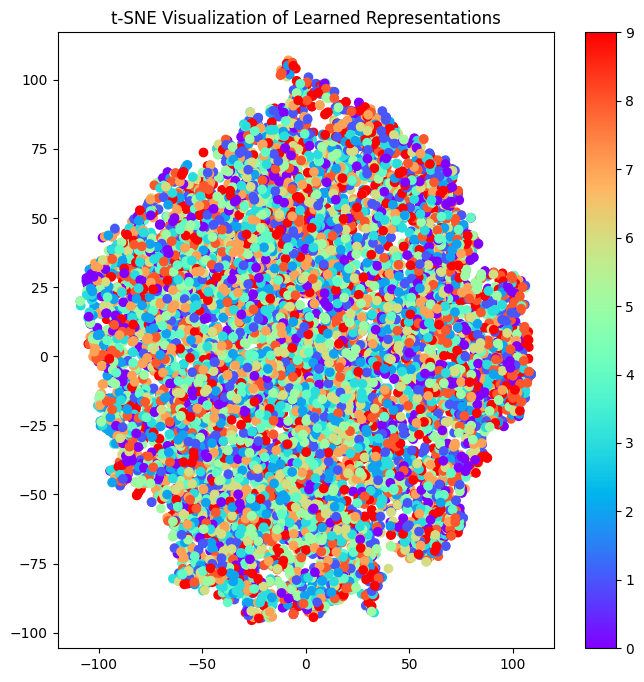

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def preprocess_data(x, y):
    x = x.astype("float32") / 255.0
    return x, y

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def create_base_model():
    base_model = applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    base_model.trainable = False
    inputs = keras.Input(shape=(32, 32, 3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(128, activation=None)(x)
    return keras.Model(inputs, outputs)

def make_pairs(images, labels):
    pair_images = []
    pair_labels = []
    labels = np.squeeze(labels)
    num_classes = np.max(labels) + 1
    idx = [np.where(labels == i)[0] for i in range(0, num_classes)]

    for idxA in range(len(images)):
        current_image = images[idxA]
        label = labels[idxA]
        idxB = np.random.choice(idx[label])
        pos_image = images[idxB]
        pair_images.append([current_image, pos_image])
        pair_labels.append([1])
        neg_idx = np.where(labels != label)[0]
        neg_image = images[np.random.choice(neg_idx)]
        pair_images.append([current_image, neg_image])
        pair_labels.append([0])

    return np.array(pair_images), np.array(pair_labels)

pair_train, label_train = make_pairs(x_train, y_train.flatten())
pair_test, label_test = make_pairs(x_test, y_test.flatten())

base_network = create_base_model()

input_a = layers.Input(shape=(32, 32, 3))
input_b = layers.Input(shape=(32, 32, 3))

processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Adjusted contrastive loss function
def contrastive_loss(y_true, y_pred):
    margin = 1
    y_true = tf.cast(y_true, tf.float32)  # Ensure y_true is float32 to match y_pred
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

distance = layers.Lambda(lambda embeddings: tf.norm(embeddings[0] - embeddings[1], axis=1, keepdims=True))([processed_a, processed_b])
outputs = layers.Dense(1, activation="sigmoid")(distance)
model = keras.Model(inputs=[input_a, input_b], outputs=outputs)

model.compile(loss=contrastive_loss, optimizer="adam", metrics=["accuracy"])

history = model.fit([pair_train[:, 0], pair_train[:, 1]], label_train[:],
                    validation_data=([pair_test[:, 0], pair_test[:, 1]], label_test[:]),
                    batch_size=128, epochs=10)

# Extract representations
representations = base_network.predict(x_test)

# t-SNE visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=3000)
tsne_results = tsne.fit_transform(representations)

plt.figure(figsize=(8, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test.flatten(), cmap='rainbow')
plt.title('t-SNE Visualization of Learned Representations')
plt.colorbar()
plt.show()


---

I modified the experiment by changing the batch size from 64 to 128. Adjusting the batch size can affect both the speed of training and the generalization performance of the model. Larger batch sizes often lead to faster training but may require more memory, while smaller batch sizes result in more frequent updates but can produce noisier gradient estimates. 
| Batch size | Running time   | Val accuracy | Val loss |
|------------|----------------|--------------|----------|
| 64         | 22 minute      | 0.392        | 0.2328   |
| 128        | 18 minute      | 0.5          | 0.25     |